In [7]:
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import Conv2D 
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.datasets import mnist
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.engine.topology import Layer,InputSpec
from keras.layers import Input
from keras.models import Model

class DNNC:
    @staticmethod
    def build(timeSteps,variables,classes):
        
        inputNet = Input(shape=(timeSteps,variables)) 
        flat=Flatten()(inputNet)
        denselayers=Dense(400)(flat)
        denselayers=Activation("relu")(denselayers)
        denselayers=Dropout(0.15)(denselayers)
        denselayers=Dense(150)(denselayers)
        denselayers=Activation("relu")(denselayers)
        denselayers=Dropout(0.15)(denselayers)
        denselayers=Dense(50)(denselayers)
        denselayers=Activation("relu")(denselayers)
        denselayers=Dropout(0.15)(denselayers)
        # a softmax classifier
        classificationLayer=Dense(1)(denselayers)
        classificationLayer=Activation("tanh")(classificationLayer)
        
        model=Model(inputNet,classificationLayer)
        return model


In [8]:
# load data
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split

def non_shuffling_train_test_split(X, y, test_size=0.2):
    i = int((1 - test_size) * X.shape[0]) + 1
    X_train, X_test = np.split(X, [i])
    y_train, y_test = np.split(y, [i])
    return X_train, X_test, y_train, y_test

# load all data
dfin = pd.read_csv('input_milk_France.csv',header=None)  #inputs 72 lines per sample
dfout = pd.read_csv('output_milk_France.csv',header=None)  #output classes 

total_inputs,total_output = dfin.as_matrix().astype(np.float32),dfout.as_matrix().astype(np.int32)

# normalize
scaler = MinMaxScaler(feature_range=(0, 1))
total_inputs = scaler.fit_transform(total_inputs)


scaler_out = MinMaxScaler(feature_range=(-1, 1))
total_output = scaler_out.fit_transform(total_output)

# every 72 lines is one input sample
total_inputs = np.reshape(total_inputs, (-1,12,4))
print("############# total shapes #############")
print(total_inputs.shape)
print(total_output.size)

train_inputs, test_inputs, train_output, test_output = non_shuffling_train_test_split(total_inputs, total_output, test_size=0.2)
print("############# train shapes #############")
print(train_inputs.shape)
print(train_output.shape)

print("############# test shapes #############")
print(test_inputs.shape)
print(test_output.shape)





############# total shapes #############
(444, 12, 4)
444
############# train shapes #############
(356, 12, 4)
(356, 1)
############# test shapes #############
(88, 12, 4)
(88, 1)


/home/rjpg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/rjpg/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [14]:

IMG_ROWS, IMG_COLS = 12, 4 # input image dimensions
NB_CLASSES = 5  # number of outputs = number of classes

X_train = train_inputs
y_train = train_output #np_utils.to_categorical(train_output, NB_CLASSES)
X_test = test_inputs
y_test = test_output#np_utils.to_categorical(test_output, NB_CLASSES)
print(y_test.shape)
OPTIMIZER = Adam()

model = DNNC.build(timeSteps=IMG_ROWS,variables=IMG_COLS,classes=NB_CLASSES)
model.compile(loss="mse", optimizer=OPTIMIZER)

model.summary()


(88, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 12, 4)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 48)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 400)               19600     
_________________________________________________________________
activation_9 (Activation)    (None, 400)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 150)               60150     
_________________________________________________________________
activation_10 (Activation)   (None, 150)               0         
__

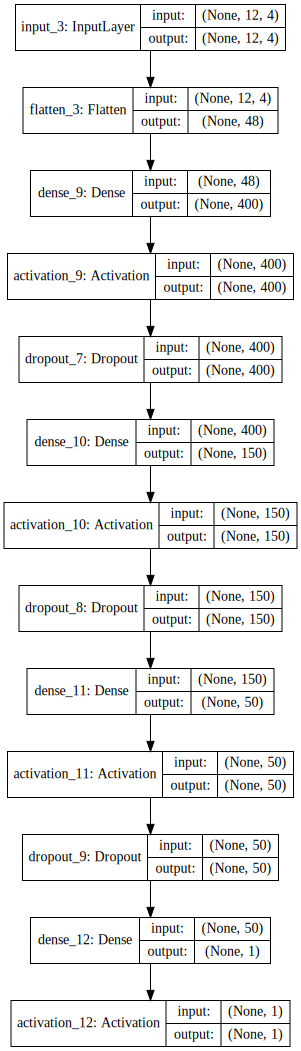

In [15]:
from IPython.display import SVG,display
from keras.utils.vis_utils import model_to_dot
modelSVG=SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
display(modelSVG)

In [16]:
NB_EPOCH = 100
BATCH_SIZE = 64
VERBOSE = 1

#tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
#esCallBack = EarlyStopping(monitor='val_acc', min_delta=0, patience=12, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)
best_checkpoint = ModelCheckpoint('DNNC-milk.h5', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
		batch_size=BATCH_SIZE, epochs=NB_EPOCH, 
		verbose=1, # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
		validation_data=(X_test,y_test),
		#validation_split=VALIDATION_SPLIT,
		callbacks=[reduce_lr,best_checkpoint])

Train on 356 samples, validate on 88 samples
Epoch 1/100
356/356 [==============================] - 7s 20ms/step - loss: 0.1774 - val_loss: 0.0692

Epoch 00001: val_loss improved from inf to 0.06924, saving model to DNNC-milk.h5
Epoch 2/100
356/356 [==============================] - 0s 93us/step - loss: 0.1096 - val_loss: 0.0483

Epoch 00002: val_loss improved from 0.06924 to 0.04827, saving model to DNNC-milk.h5
Epoch 3/100
356/356 [==============================] - 0s 88us/step - loss: 0.0810 - val_loss: 0.0431

Epoch 00003: val_loss improved from 0.04827 to 0.04313, saving model to DNNC-milk.h5
Epoch 4/100
356/356 [==============================] - 0s 74us/step - loss: 0.0688 - val_loss: 0.0496

Epoch 00004: val_loss did not improve from 0.04313
Epoch 5/100
356/356 [==============================] - 0s 90us/step - loss: 0.0545 - val_loss: 0.0606

Epoch 00005: val_loss did not improve from 0.04313
Epoch 6/100
356/356 [==============================] - 0s 74us/step - loss: 0.0459 - va

356/356 [==============================] - 0s 79us/step - loss: 0.0208 - val_loss: 0.0338

Epoch 00052: val_loss did not improve from 0.02596
Epoch 53/100
356/356 [==============================] - 0s 92us/step - loss: 0.0219 - val_loss: 0.0327

Epoch 00053: val_loss did not improve from 0.02596
Epoch 54/100
356/356 [==============================] - 0s 92us/step - loss: 0.0213 - val_loss: 0.0368

Epoch 00054: val_loss did not improve from 0.02596
Epoch 55/100
356/356 [==============================] - 0s 111us/step - loss: 0.0204 - val_loss: 0.0337

Epoch 00055: val_loss did not improve from 0.02596
Epoch 56/100
356/356 [==============================] - 0s 79us/step - loss: 0.0215 - val_loss: 0.0297

Epoch 00056: val_loss did not improve from 0.02596
Epoch 57/100
356/356 [==============================] - 0s 87us/step - loss: 0.0206 - val_loss: 0.0350

Epoch 00057: val_loss did not improve from 0.02596
Epoch 58/100
356/356 [==============================] - 0s 89us/step - loss: 0.021

In [17]:
import json,codecs
import numpy as np
def saveHist(path,history):

    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
           if  type(history.history[key][0]) == np.float64:
               new_hist[key] = list(map(float, history.history[key]))

    #print(new_hist)
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 

def loadHist(path):
    with codecs.open(path, 'r', encoding='utf-8') as f:
        n = json.loads(f.read())
    return n


saveHist('DNNC-milk.hist',history)
hist=loadHist('DNNC-milk.hist')




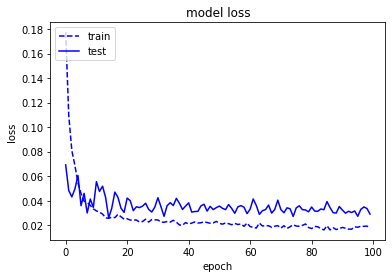

In [20]:
import matplotlib.pylab as plt

#acc=np.array(hist['acc'])
#acc=acc[0:100]
#acc=np.append(acc,[0.7])

#plt.plot(acc,'b--')
#plt.plot(hist['val_acc'],'b',label='DNNC')
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(loc='upper left')
#plt.show()

# summarize history for loss
loss=np.array(hist['loss'])
#loss=np.append(loss,[2])
plt.plot(loss,'b--',label='train')
plt.plot(hist['val_loss'],'b',label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()